In [251]:
""" Script regresses control models against RNN RDM to find best fit"""

In [232]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


from cryptic_rnn import *

In [951]:
## functions

def tuple_output(tuple_step, cue_dict):
    out = cue_dict[tuple_step[1]]
    if tuple_step[0]=='-':
        out = -1*out
    return out

#### functions ###################
def control_importance(rdm, val_idx, all_seqs, cuedict):

    outs_truth = change_dict(all_seqs, cuedict)
    outs_truth = [t[-1] for t in outs_truth]
    truth_RDM = abs(np.array([outs_truth]*16) - np.array([outs_truth]*16).T)
       
    outs_aug = change_dict(all_seqs, cuedict)
    outs_aug = [tuple_output(t[0], cuedict) for t in outs_aug]
    aug_RDM = abs(np.array([outs_aug]*16) - np.array([outs_aug]*16).T)

    y = []
    x_truth = []
    x_aug = []
    for p in val_idx:
        for q in val_idx:
            y.append(rdm[p,q])
            x_truth.append(truth_RDM[p,q])
            x_aug.append(aug_RDM[p,q])

    y = np.array(y)#.reshape(-1,1)
    x = pd.DataFrame({'ground_truth': np.array(x_truth),
                      'aug_control': np.array(x_aug)})
    
    lm = ols('y ~ ground_truth + aug_control',x).fit()
    lm.params
    anova_table = anova_lm(lm)
    var_vals = anova_table.loc[:,'sum_sq'] / anova_table['sum_sq'].sum()
    var_exp = np.array(var_vals[:-1])
    return var_exp

def get_step_coeffs(RDMs, step_num):
    importance_vals = np.empty((0,2))
    for i, rdm_mat in enumerate(RDMs[step_num]):
        imps = control_importance(rdm_mat, val_idx, all_seqs, ft_cue_dicts[i])
        importance_vals = np.vstack([importance_vals, imps])
   
    coeff_vals = importance_vals.T.reshape(-1)
    print(len(RDMs[0]))
    N = len(RDMs[0])
    control_mod = ['ground truth']*N + ['augend']*N
    return coeff_vals, control_mod

def all_steps_coeffs(RDM_set):
    all_coeffs = np.empty((0,1))
    all_controls = []
    step_num = []
    for st in range(4):
        print('step ', st)
        step_coeffs, step_mods = get_step_coeffs(RDM_set, step_num=st)
        all_coeffs = np.append(all_coeffs, step_coeffs)
        all_controls += step_mods
        step_num += [st+1]*len(step_mods)
    return pd.DataFrame({'step': step_num, 'variance explained': all_coeffs, 'control':all_controls})


def regress_single_control(rdm_list, cuedict_list, val_idx, all_seqs):
    all_r2s = []
    for i, rdm in enumerate(rdm_list):
        cuedict = cuedict_list[i]
        
        outs_truth = np.linspace(-10, 10 , len(all_seqs))
        truth_RDM = abs(np.array([outs_truth]*16) - np.array([outs_truth]*16).T)

        y = []
        x_truth = []
        for p in val_idx:
            for q in val_idx:
                y.append(rdm[p,q])
                x_truth.append(truth_RDM[p,q])
                
        y = np.array(y)#.reshape(-1,1)
        x = pd.DataFrame({'ground_truth': np.array(x_truth)})

        lm = ols('y ~ ground_truth',x).fit()
        lm.params
        anova_table = anova_lm(lm)
        var_vals = anova_table.loc[:,'sum_sq'] / anova_table['sum_sq'].sum()
        var_exp = np.array(var_vals[:-1])
        all_r2s.append(var_exp[0])
    return all_r2s


plt.rcParams.update({'font.size': 14})

In [952]:
np.mean(regress_single_control(dms_p[2], ft_cue_dicts, val_idx, all_seqs ))

0.5220548259885974

In [953]:
np.mean(regress_single_control(dms_b[2], ft_cue_dicts, val_idx, all_seqs ))

0.4311304540228285

In [946]:
np.arange(10)/np.linalg.norm(np.arange(10))

array([0.        , 0.05923489, 0.11846978, 0.17770466, 0.23693955,
       0.29617444, 0.35540933, 0.41464421, 0.4738791 , 0.53311399])

In [950]:
mt = 16
np.linspace(-10, 10 , mt)

array([-10.        ,  -8.66666667,  -7.33333333,  -6.        ,
        -4.66666667,  -3.33333333,  -2.        ,  -0.66666667,
         0.66666667,   2.        ,   3.33333333,   4.66666667,
         6.        ,   7.33333333,   8.66666667,  10.        ])

In [948]:
20/mt

1.25

In [931]:
# RNN params
num_classes = 22
batchsize=1
hidden_size = 20

rank_dict = {'A': -1.5, 'B': -0.5, 'C':0.5 , 'D':1.5 }
## sequences
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
primitives = generate_pos_primitives(all_syms, cue_dict)

trainseqs = generate_pos_other(ops, all_syms[:-1], cue_dict)
trainseqs_b = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_balanced_primitives(ops, all_syms, cue_dict)
trainseqs_p = trainseqs + primitives
trainseqs_bp = trainseqs_b + primitives

all_seqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in all_seqs if seq not in trainseqs_b]
val_idx = [idx for idx, seq in enumerate(testseqs_all) if seq not in trainseqs_b]

## read data 
save_dir = '../results/addition_trigrams_3inputs_bp_1000'
with open(save_dir, 'rb') as f:
    res1 = pickle.load(f)
    
full_rdmats = calculate_RDMs(res1, testseqs_all, subset = 'all')
dms = full_rdmats['rdms']
dms_p = full_rdmats['rdms_p']
dms_b = full_rdmats['rdms_b']
dms_bp = full_rdmats['rdms_bp']
ft_cue_dicts =  full_rdmats['ft_cue_dicts']

KeyboardInterrupt: 

In [867]:
df_p = all_steps_coeffs(dms_p)
df_b = all_steps_coeffs(dms_b)

step  0
1000
step  1
1000
step  2
1000
step  3
1000
step  0
1000
step  1
1000
step  2
1000
step  3
1000


In [873]:
df_p

,step,variance explained,control
0,1,0.175080,ground truth
1,1,0.114212,ground truth
2,1,0.103350,ground truth
3,1,0.120227,ground truth
4,1,0.140414,ground truth
...,...,...,...
7995,4,0.037012,augend
7996,4,0.000099,augend
7997,4,0.000005,augend
7998,4,0.000573,augend


In [907]:
y_mu = np.array([y1 , y2, y3, y4]).mean(axis=1)
y_std_err = np.array([y1 , y2, y3, y4]).std(axis=1)/math.sqrt(len(y1))

array([0.00160469, 0.00900908, 0.01293274, 0.00455024])

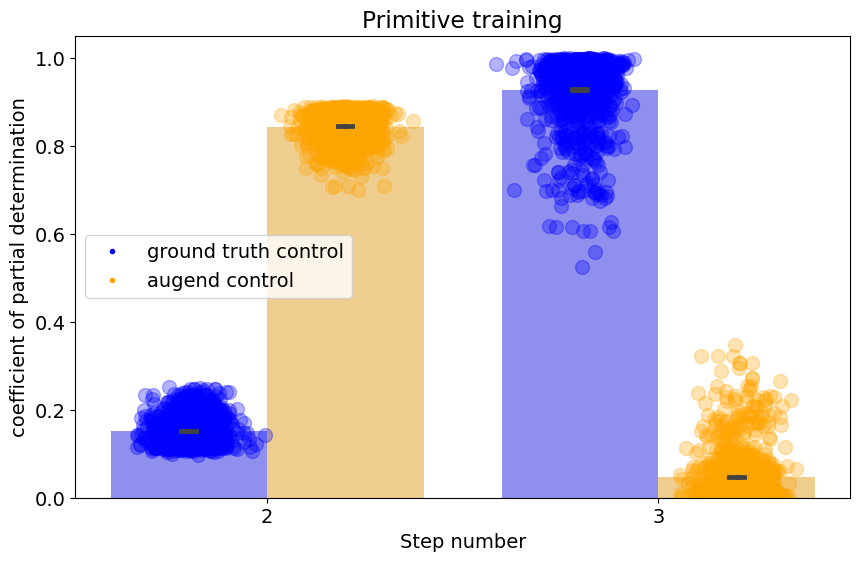

In [934]:
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='ground truth control'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='augend control')]
colors = ['blue', 'orange']

df_p_23 = df_p[df_p['step'].isin(steps)]


steps = [2,3]
shift = 0.2
N = len(dms_b[0])
xpos = np.array([[0-shift]*N, [0+shift]*N, [1-shift]*N, [1+shift]*N])
x_jitter = xpos + np.random.normal(0, 0.05, 4*N).reshape(4, N)

y1 = df_p[(df_p['step'] == steps[0])&(df_p['control'] == 'ground truth')]['variance explained']
y2 = df_p[(df_p['step'] == steps[0])&(df_p['control'] == 'augend')]['variance explained']
y3 = df_p[(df_p['step'] == steps[1])&(df_p['control'] == 'ground truth')]['variance explained']
y4 = df_p[(df_p['step'] == steps[1])&(df_p['control'] == 'augend')]['variance explained']
ys = [y1 , y2, y3, y4]

fig, axs = plt.subplots()
sns.barplot(df_p_23, x = 'step', y='variance explained', hue='control', errorbar="se", alpha=0.5, palette=colors, capsize=0.04)

for i in range(4):
    axs.scatter(x_jitter[i,:], ys[i], alpha=0.3, color =colors[i%2], s=100, label = labels[i%2])
axs.set_ylabel('coefficient of partial determination')
axs.set_xticks(np.arange(len(steps)))
axs.set_xticklabels(steps)
axs.set_xlabel('Step number')
axs.title.set_text('Primitive training')
axs.legend(handles=legend_elements)

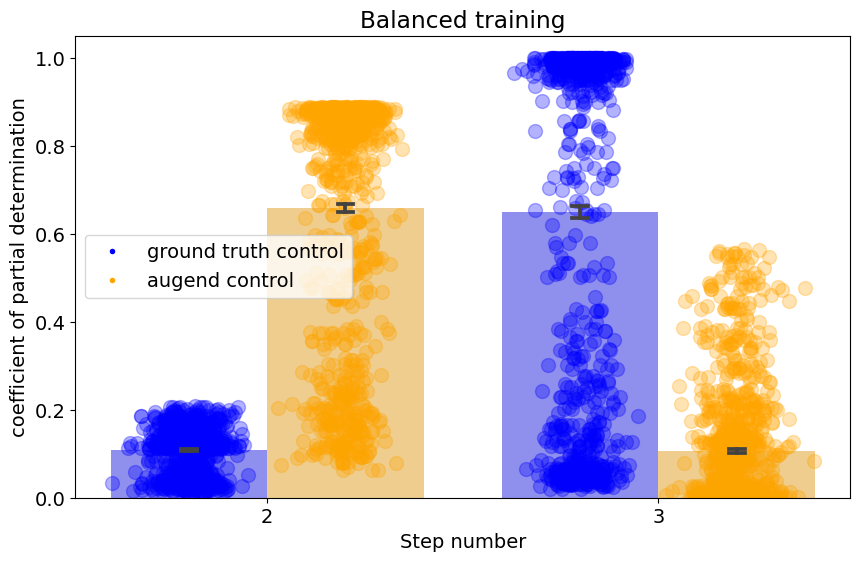

In [933]:
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='ground truth control'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='augend control')]
colors = ['blue', 'orange']

df_b_23 = df_b[df_b['step'].isin(steps)]


steps = [2,3]
shift = 0.2
N = len(dms_b[0])
xpos = np.array([[0-shift]*N, [0+shift]*N, [1-shift]*N, [1+shift]*N])
x_jitter = xpos + np.random.normal(0, 0.05, 4*N).reshape(4, N)

y1 = df_b[(df_b['step'] == steps[0])&(df_b['control'] == 'ground truth')]['variance explained']
y2 = df_b[(df_b['step'] == steps[0])&(df_b['control'] == 'augend')]['variance explained']
y3 = df_b[(df_b['step'] == steps[1])&(df_b['control'] == 'ground truth')]['variance explained']
y4 = df_b[(df_b['step'] == steps[1])&(df_b['control'] == 'augend')]['variance explained']
ys = [y1 , y2, y3, y4]

fig, axs = plt.subplots()
sns.barplot(df_b_23, x = 'step', y='variance explained', hue='control', errorbar="se", alpha=0.5, palette=colors, capsize=0.04)

for i in range(4):
    axs.scatter(x_jitter[i,:], ys[i], alpha=0.3, color =colors[i%2], s=100, label = labels[i%2])
axs.set_ylabel('coefficient of partial determination')
axs.set_xticks(np.arange(len(steps)))
axs.set_xticklabels(steps)
axs.set_xlabel('Step number')
axs.title.set_text('Balanced training')
axs.legend(handles=legend_elements)